In [ ]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import GLSAR
import warnings
warnings.filterwarnings('ignore')

def calculate_gls2_elasticity(annual_data, window_years=20):
    """
    Calculation of GLS2 elasticity coefficients (e_Q/P and e_Q/EP)
    """
    if len(annual_data) < window_years:
        return None
    
    long_term_mean = annual_data.mean()
    windows_data = []
    for i in range(len(annual_data) - window_years + 1):
        window = annual_data.iloc[i:i+window_years]
        window_mean = window.mean()
        windows_data.append({
            'delta_Q': window_mean['streamflow'] - long_term_mean['streamflow'],
            'delta_P': window_mean['total_precipitation_sum'] - long_term_mean['total_precipitation_sum'],
            'delta_EP': window_mean['potential_evaporation_sum_FAO_PENMAN_MONTEITH'] - long_term_mean['potential_evaporation_sum_FAO_PENMAN_MONTEITH']
        })
    windows_df = pd.DataFrame(windows_data).dropna()
    if len(windows_df) < 3:
        return None

    y = windows_df['delta_Q'].values
    X = sm.add_constant(windows_df[['delta_P', 'delta_EP']].values)
    try:
        gls_model = GLSAR(y, X, rho=1)
        gls_results = gls_model.iterative_fit(maxiter=20)
        return {
            'e_Q_P': gls_results.params[1],
            'e_Q_EP': gls_results.params[2]
        }
    except:
        return None

def process_station_data(filepath):
    """
    Process data for a single station and return annual aggregation
    """
    try:
        df = pd.read_csv(filepath, parse_dates=['date'])
        df['water_year'] = df['date'].apply(lambda d: d.year + 1 if d.month >= 10 else d.year)
        valid = df[~df['streamflow'].isna()]
        if valid.empty:
            return None
        start_date, end_date = valid['date'].min(), valid['date'].max()
        df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
        df['water_year'] = df['date'].apply(lambda d: d.year + 1 if d.month >= 10 else d.year)
        required_cols = ['streamflow', 'total_precipitation_sum', 'potential_evaporation_sum_FAO_PENMAN_MONTEITH']
        df['valid_day'] = (~df[required_cols].isna().any(axis=1)).astype(int)
        days_per_year = df.groupby('water_year')['valid_day'].sum()
        valid_years = days_per_year[days_per_year >= 300].index
        if len(valid_years) < 10:
            return None
        df_valid = df[df['water_year'].isin(valid_years)]
        annual = df_valid.groupby('water_year').agg({
            'total_precipitation_sum': 'sum',
            'potential_evaporation_sum_FAO_PENMAN_MONTEITH': 'sum',
            'streamflow': 'sum'
        }).dropna()
        if len(annual) < 20:
            return None
        return annual
    except:
        return None

def main():
    data_folder = r'timeseries/csv/grdc/processed'
    if not os.path.exists(data_folder):
        print(f"Error: Data folder '{data_folder}' does not exist!")
        return
    results = []
    csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    print(f"Found {len(csv_files)} CSV files to process...")
    for i, filename in enumerate(csv_files):
        station_id = filename.replace('.csv', '')
        filepath = os.path.join(data_folder, filename)
        print(f"Processing {i+1}/{len(csv_files)}: {station_id}")
        annual_data = process_station_data(filepath)
        if annual_data is None:
            print(f"  -> Skipped: insufficient data")
            continue
        gls2_result = calculate_gls2_elasticity(annual_data)
        if gls2_result:
            results.append({
                'station_id': station_id,
                'n_years': len(annual_data),
                'e_Q_P': gls2_result['e_Q_P'],
                'e_Q_EP': gls2_result['e_Q_EP']
            })
    # Convert to DataFrame
    df_result = pd.DataFrame(results)
    # Remove outliers
    df_result = df_result[(df_result['e_Q_P'] >= -5) & (df_result['e_Q_P'] <= 5)]
    df_result = df_result[(df_result['e_Q_EP'] >= -5) & (df_result['e_Q_EP'] <= 5)]
    output_filename = 'elasticity_gls2_cleaned.csv'
    df_result.to_csv(output_filename, index=False)
    print(f"Saved {len(df_result)} valid results to {output_filename}")

if __name__ == "__main__":
    main()


Found 5356 CSV files to process...
Processing 1/5356: GRDC_1159100
Processing 2/5356: GRDC_1159103
Processing 3/5356: GRDC_1159105
  -> Skipped: insufficient data
Processing 4/5356: GRDC_1159110
Processing 5/5356: GRDC_1159120
Processing 6/5356: GRDC_1159125
Processing 7/5356: GRDC_1159130
Processing 8/5356: GRDC_1159131
Processing 9/5356: GRDC_1159290
Processing 10/5356: GRDC_1159300
Processing 11/5356: GRDC_1159301
Processing 12/5356: GRDC_1159302
Processing 13/5356: GRDC_1159304
  -> Skipped: insufficient data
Processing 14/5356: GRDC_1159305
Processing 15/5356: GRDC_1159310
Processing 16/5356: GRDC_1159320
Processing 17/5356: GRDC_1159321
Processing 18/5356: GRDC_1159325
  -> Skipped: insufficient data
Processing 19/5356: GRDC_1159330
Processing 20/5356: GRDC_1159333
Processing 21/5356: GRDC_1159335
Processing 22/5356: GRDC_1159337
Processing 23/5356: GRDC_1159400
Processing 24/5356: GRDC_1159403
Processing 25/5356: GRDC_1159405
Processing 26/5356: GRDC_1159410
Processing 27/5356: 

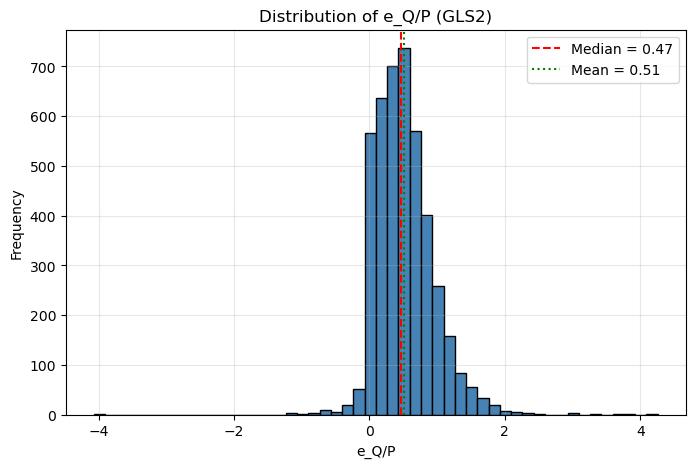

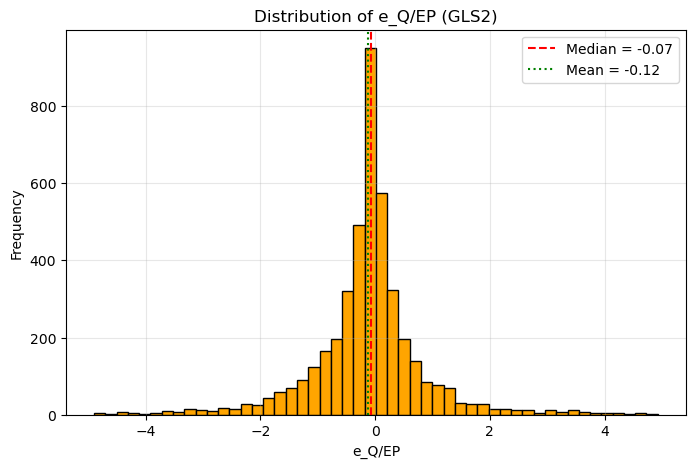

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("elasticity_gls2_cleaned.csv")

df = df.dropna(subset=['e_Q_P', 'e_Q_EP'])

plt.figure(figsize=(8,5))
plt.hist(df['e_Q_P'], bins=50, color='steelblue', edgecolor='black')
plt.axvline(df['e_Q_P'].median(), color='red', linestyle='--', label=f"Median = {df['e_Q_P'].median():.2f}")
plt.axvline(df['e_Q_P'].mean(), color='green', linestyle=':', label=f"Mean = {df['e_Q_P'].mean():.2f}")
plt.title("Distribution of e_Q/P (GLS2)")
plt.xlabel("e_Q/P")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df['e_Q_EP'], bins=50, color='orange', edgecolor='black')
plt.axvline(df['e_Q_EP'].median(), color='red', linestyle='--', label=f"Median = {df['e_Q_EP'].median():.2f}")
plt.axvline(df['e_Q_EP'].mean(), color='green', linestyle=':', label=f"Mean = {df['e_Q_EP'].mean():.2f}")
plt.title("Distribution of e_Q/EP (GLS2)")
plt.xlabel("e_Q/EP")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
